## Spooky Author Identification 
### 무시무시한 글에 대한 작성자 식별
이 경진대회는 할로윈 때 올라 온 경진대회로 호러물에 대한 저자가 누구인지 알아내는 경진대회다.

```
어느 날 양초를 들고 묶여져 있지 않은 책을 들고 으스스한 방을 걷고 있었다. 이제 책이 완성되었다고 생각하고 있는데 갑자기 전화벨이 울리고 Kaggle 중재자 중 가장 무서운 Will이 데이터 유출 소식을 공유했다. 그리고 책을 떨어뜨렸다.
묶여져 있지 않은 글을 쏟아서 뒤죽박죽이 되었다. 이때 저자별로 글을 모아야 하는데 어떻게 해야 할까? 기계학습의 손을 빌려 저자별로 글을 모아본다.
```


* 경진대회 정보 : [Spooky Author Identification | Kaggle](https://www.kaggle.com/c/spooky-author-identification)

* 참고: https://www.kaggle.com/sathvisiva/exploring-spooky-author-dataset


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import string, re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter


import scipy

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

import xgboost as xgb


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
train.shape

(19579, 3)

In [3]:
test = pd.read_csv('data/test.csv')
test.shape

(8392, 2)

In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
print(train.isnull().sum())

id        0
text      0
author    0
dtype: int64


In [6]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

1. [EAP - 
Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe): 
[에드거 앨런 포](https://ko.wikipedia.org/wiki/%EC%97%90%EB%93%9C%EA%B1%B0_%EC%95%A8%EB%9F%B0_%ED%8F%AC) 1809년 1월 19일 ~ 1849년 10월 7일)는 미국의 작가·시인·편집자·문학평론가이다. 미국 낭만주의의 거두이자 미국 문학사 전체적으로 매우 중요하게 취급되는 작가이다. 미스터리 및 마카브레 작품들로 가장 유명하며, 미국 단편 소설의 선구자이기도 하다. 또한, 추리소설이라는 장르를 최초로 만들어냈다고 평가받으며, 나아가 과학소설 장르의 형성에 이바지했다. 그는 오로지 저술과 집필을 통해서만 생활하려 한 미국 최초의 전업작가이며, 이 때문에 생전에 심한 재정난과 생활고를 겪으며 유년기를 제외한 평생을 불우하게 살았다.

2. [HPL - HP Lovecraft 하워드 필립스 러브크래프트](https://ko.wikipedia.org/wiki/H._P._%EB%9F%AC%EB%B8%8C%ED%81%AC%EB%9E%98%ED%94%84%ED%8A%B8)
: 1890년 8월 20일 ~ 1937년 3월 15일)는 미국의 호러, 판타지, 공상과학 소설가이다. 
미국 로드아일랜드 주 프로비던스 시에서 태어났다. 인스머스의 그림자와 크툴루의 부름 등 수많은 단편을 썼다. 그가 만들어낸 일련의 신화 체계는 후대의 작가들에게도 영감을 불어넣어, 수많은 소설가들이 그걸 이어받아 크툴루 신화로 발전시켰다. 1934년부터 암 증세가 서서히 일어나기 시작했지만 단순한 소화불량으로 여기다 고통을 이기지 못해 1937년 3월, 병원을 찾아갔지만 이미 암이 온몸 곳곳에 퍼진 후였다. 결국 입원 5일 뒤 1937년 3월 15일 암으로 사망했다. 자신의 고향에 묘가 세워졌지만 비석은 약 40여 년 후인 1978년에 독자들에 의해 세워졌다.

3. [MWS - Mary Shelley 메리 셸리](https://ko.wikipedia.org/wiki/%EB%A9%94%EB%A6%AC_%EC%85%B8%EB%A6%AC)
: 메리 셸리(Mary Shelley, 혼전이름: 메리 울스턴크래프트 고드윈(Mary Wollstonecraft Godwin), 1797년 8월 30일 ~ 1851년 2월 1일)는 영국의 소설가·극작가·수필가·전기 작가이자 여행 작가이다. 그는 또한 낭만주의 시인이자 철학자인 남편 퍼시 비시 셸리의 작품을 편집하고 소개하기도 하였다. 정치철학자 윌리엄 고드윈, 철학자이자 여권운동가 메리 울스턴크래프트 부부의 딸이다.

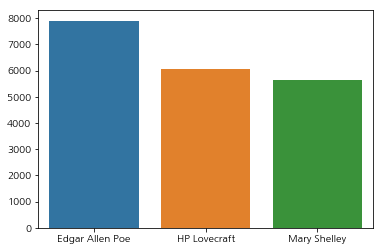

In [7]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

x = train.author.map(z).unique()
y = train.author.value_counts().values
y
sns.barplot(x=x, y=y)

In [8]:
# 저자별로 데이터프레임을 나눈다.
train_eap = train[train["author"] == 'EAP']["text"]
train_hpl = train[train["author"] == 'HPL']["text"]
train_mws = train[train["author"] == 'MWS']["text"]

## Natural Language Processing

In [9]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [10]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal 불용어 제거

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to"또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 영어 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [12]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("원래 문장 길이: {0} words\n"
      "stopwords 제거 후 길이: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
원래 문장 길이: 48 words
stopwords 제거 후 길이: 28 words


## Stemming and Lemmatization
### 스테밍(어간추출)
출처 : [어간 추출 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)


어간 추출(語幹 抽出, 영어: stemming)은 형태론 및 정보 검색 분야에서 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것을 의미한다. 여기서 어간은 반드시 어근과 같아야 할 필요는 없으며, 어근과 차이가 있더라도 관련이 있는 단어들이 일정하게 동일한 어간으로 맵핑되게 하는 것이 어간 추출의 목적이다. 1960년대부터 컴퓨터 과학 분야에서 다양한 어간 추출 관련 알고리즘들이 연구되어 왔다. 많은 웹 검색 엔진들은 동일한 어간을 가진 단어들을 동의어로 취급하는 방식으로 질의어 확장을 하여 검색 결과의 품질을 높인다.

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화하는 과정이다. 동음이의어가 문맥에 따라 다른 의미를 갖는데 
<pre>
1) *배*가 맛있다. 
2) *배*를 타는 것이 재미있다. 
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
</pre>
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다. <br/>
레마타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.


In [13]:
stemmer = nltk.stem.PorterStemmer()

In [14]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [15]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


In [16]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
stemmer

def stem_phrase(phrase):
    stemmed_words = [stemmer.stem(w) for w in phrase.split(" ")]
    stemmed_phrase = " ".join(stemmed_words)
    
    return stemmed_phrase


train["text"] = train["text"].apply(stem_phrase)
test["text"] = test["text"].apply(stem_phrase)

In [17]:
#length of unique words
train["unique_words"] = train["text"].apply(lambda x : len(set(x.split())))
test["unique_words"] = test["text"].apply(lambda x : len(set(x.split())))
# length of stop words
# stopwords = nltk.corpus.stopwords.words('english')
train["stop_words"] = train["text"].apply(lambda x : len([w for w in str(x).split() if w in stopwords]))
test["stop_words"] = test["text"].apply(lambda x : len([w for w in str(x).split() if w in stopwords]))
train["stop_words"].head()

0    19
1     7
2    16
3    13
4    11
Name: stop_words, dtype: int64

In [18]:
train['num_words'] = train['text'].apply(lambda x: len(str(x).split()))
test['num_words'] = test['text'].apply(lambda x: len(str(x).split()))

train['num_uniq_words'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['num_uniq_words'] = test['text'].apply(lambda x: len(set(str(x).split())))


# length of punctuations
# 구두점 갯수
train["punctuations"] = train["text"].apply(lambda x : len([w for w in str(x) if w in string.punctuation]))
test["punctuations"] = test["text"].apply(lambda x : len([w for w in str(x) if w in string.punctuation]))

# upper case letters
# 대문자 수
train["upper_case"] = train["text"].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))
test["upper_case"] = test["text"].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))

# title letters
# 제목
train["Title"] = train["text"].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))
test["Title"] = test["text"].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))


In [19]:
train['split'] = train.text.apply(nltk.word_tokenize)

# Save a mapping of all (unique) csv words to integers
unique_words = {word for sentence in train.split.values for word in sentence}
dict_csv = {s: i for i,s in enumerate(unique_words)}

# Apply stemming (Snowball). We also exclude stopwords in this step,
# as well as punctuation
stopwords = nltk.corpus.stopwords.words('english') + ['']

# Create dictionaries from words to stem and conversely
stemmer_dict = {u: stemmer.stem(u) for u in unique_words}
reverse_stemmer = {u: [] for u in stemmer_dict.values()}
for k in stemmer_dict:
    reverse_stemmer[stemmer_dict[k]].append(k)
train['stemmed'] = train['split'].apply(lambda x: [stemmer_dict[y] for y in x \
                                               if re.sub('[^a-z]+','',y.lower()) not in stopwords])


# Count words overall and by author
word_count = {'ALL': pd.Series([y for x in train.stemmed for y in x]).value_counts()}
authors = ['MWS', 'EAP', 'HPL']
authors_dict = {auth: i for i, auth in enumerate(authors)}
for auth in authors:
    word_count[auth] = pd.Series([y for x in train.loc[train.author==auth, 'stemmed'] \
                                  for y in x]).value_counts()
word_count = pd.DataFrame(word_count).fillna(0).astype(int).sort_values('ALL', ascending=False)[['ALL']+authors]

print('Count for the most common words (excl. stopwords)')

word_count.head(10).style.background_gradient(subset=authors,
                                              cmap=LinearSegmentedColormap.from_list('', ['ivory','yellow']))

Count for the most common words (excl. stopwords)


,ALL,MWS,EAP,HPL
one,1677,489,672,516
upon,1411,200,1025,186
could,1331,383,458,490
would,1258,475,416,367
veri,919,134,536,249
time,874,278,315,281
on,839,264,263,312
even,828,298,296,234
man,786,249,258,279
day,743,288,258,197


In [20]:
train.drop('stemmed',inplace=True,axis=1)

In [21]:
def displayWordCloud(data = None, backgroundcolor = 'black',  width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

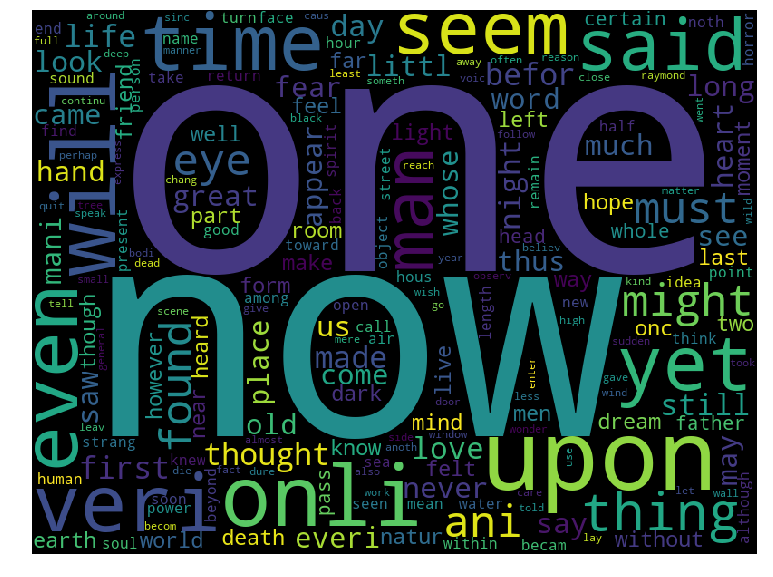

In [22]:
# 모든 단어에 대한 워드 클라우드를 그려본다.
displayWordCloud(' '.join(train['text']))

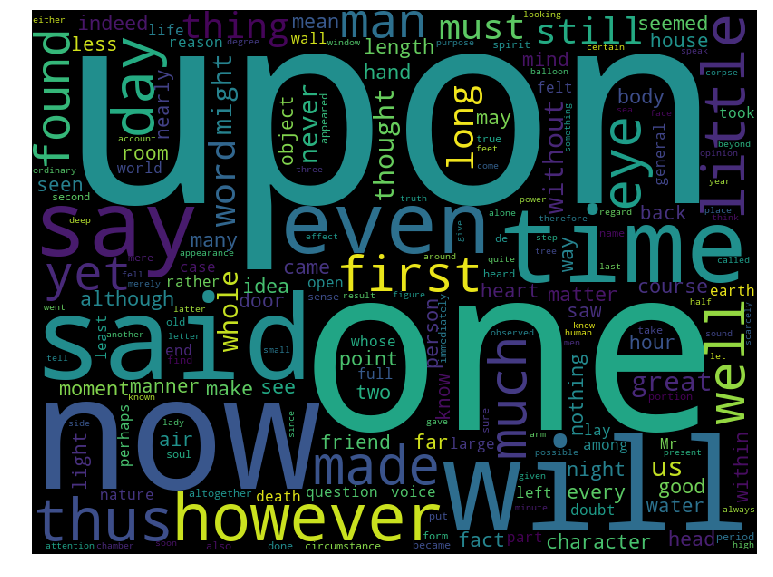

In [23]:
# 에드거 앨런 포(EAP)의 글에 대한 워드클라우드를 그려본다. 
displayWordCloud(' '.join(train_eap))

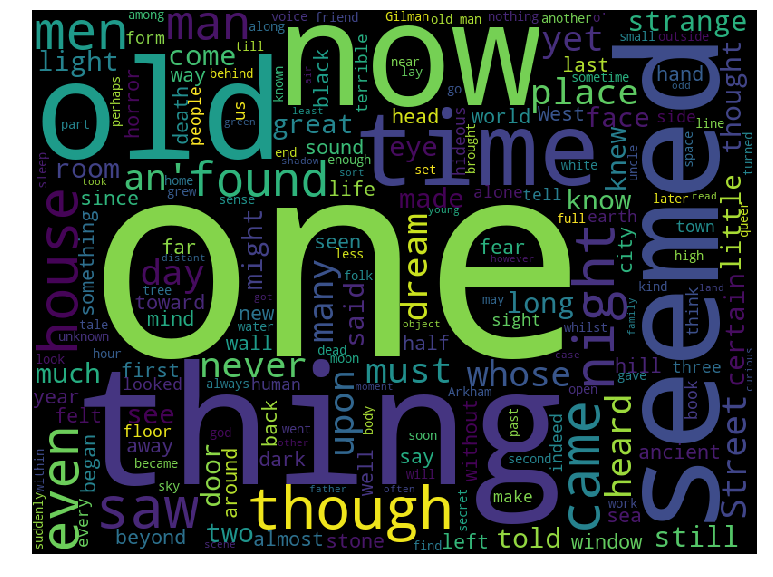

In [24]:
displayWordCloud(' '.join(train_hpl))

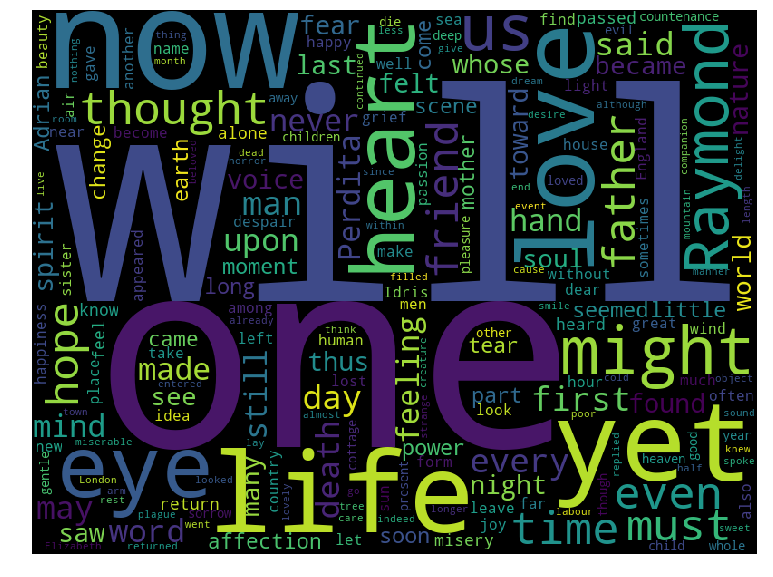

In [25]:
displayWordCloud(' '.join(train_mws))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122d180f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1227dcef0>]], dtype=object)

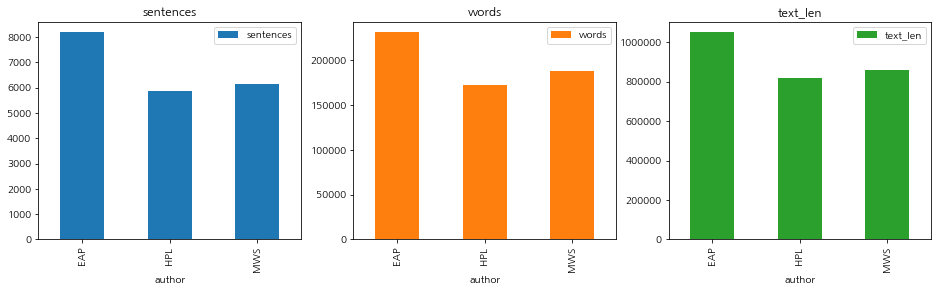

In [26]:
train['sentences'] = train.text.transform(lambda x: len(sent_tokenize(x)))
train['words'] = train.text.transform(lambda x: len(word_tokenize(x)))
train['text_len'] = train.text.transform(lambda x: len(x))

test['sentences'] = test.text.transform(lambda x: len(sent_tokenize(x)))
test['words'] = test.text.transform(lambda x: len(word_tokenize(x)))
test['text_len'] = test.text.transform(lambda x: len(x))

train.groupby("author")[['sentences','words','text_len']].sum().plot.bar(subplots = True, layout=(1,3), figsize=(16,4))

In [27]:
import string
def unique_word_fraction(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    unique_count = list(set(text_splited)).__len__()
    return (unique_count/word_count)


eng_stopwords = nltk.corpus.stopwords.words('english')
# eng_stopwords = set(stopwords.words("english"))
def stopwords_count(row):
    """ Number of stopwords fraction in a text"""
    text = row['text'].lower()
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    stopwords_count = len([w for w in text_splited if w in eng_stopwords])
    return (stopwords_count/word_count)

def punctuations_fraction(row):
    """functiopn to claculate the fraction of punctuations over total number of characters for a given text """
    text = row['text']
    char_count = len(text)
    punctuation_count = len([c for c in text if c in string.punctuation])
    return (punctuation_count/char_count)


def char_count(row):
    """function to return number of chracters """
    return len(row['text'])

def fraction_noun(row):
    """function to give us fraction of noun over total words """
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    return (noun_count/word_count)

def fraction_adj(row):
    """function to give us fraction of adjectives over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    adj_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    return (adj_count/word_count)

def fraction_verbs(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return (verbs_count/word_count)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122e4c978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ff8c7b8>]], dtype=object)

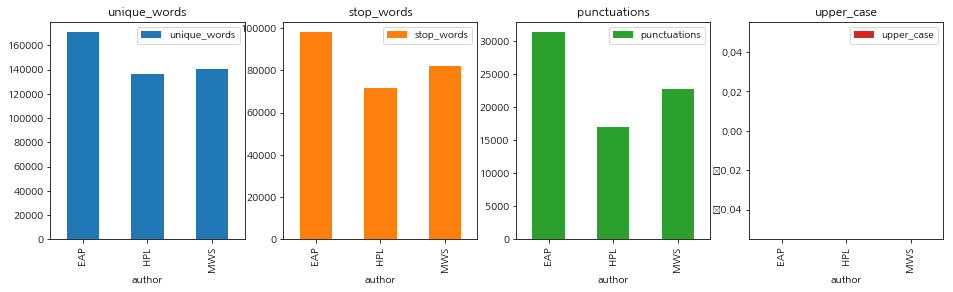

In [28]:
train.groupby('author')[['unique_words' , 'stop_words' , 'punctuations' , 'upper_case'
                        ]].sum().plot.bar(subplots = True, layout = (1,4), figsize = (16,4))

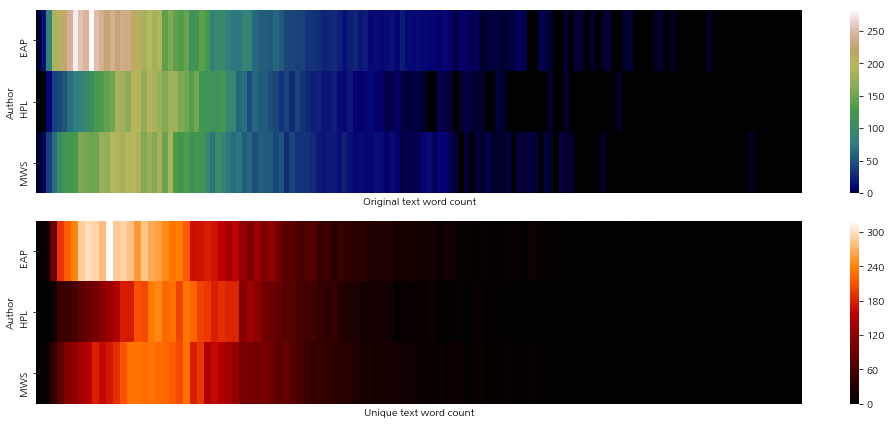

In [29]:
plt.figure(figsize=(14,6))
plt.subplot(211)
sns.heatmap(pd.crosstab(train['author'],train['num_words']),cmap='gist_earth',xticklabels=False)
plt.xlabel('Original text word count')
plt.ylabel('Author')

plt.subplot(212)
sns.heatmap(pd.crosstab(train['author'],train['num_uniq_words']),cmap='gist_heat',xticklabels=False)
plt.xlabel('Unique text word count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

Text(0.5,1,'Distribution of original text words')

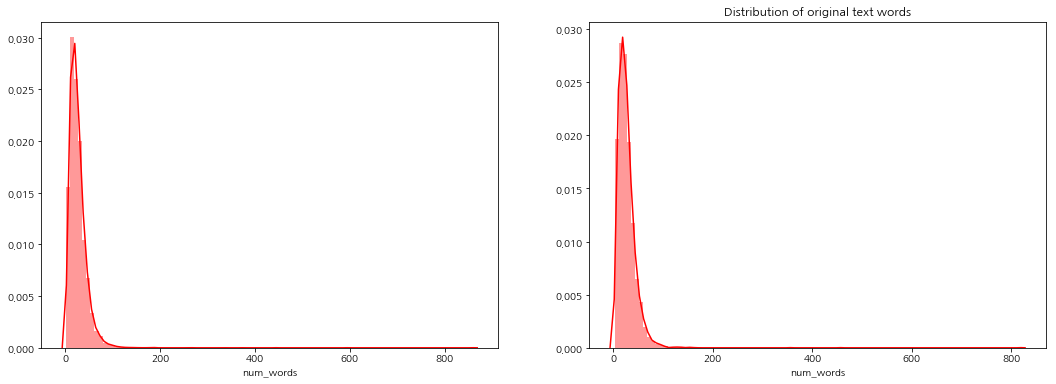

In [30]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
sns.distplot(train['num_words'],bins=100,color='r', ax=axes[0])
sns.distplot(test['num_words'],bins=100,color='r', ax=axes[1])
plt.title('Distribution of original text words')

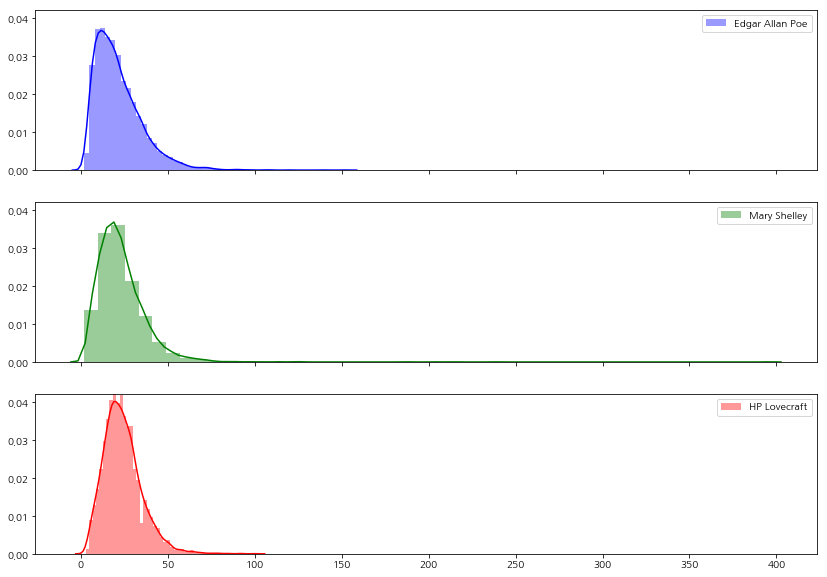

Time taken by above cell is 0.7554759979248047.


In [31]:
import time
start = time.time()
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14,10))
sns.distplot(train.loc[train['author']=='EAP']['unique_words'].values, ax=axes[0], color='blue', label='Edgar Allan Poe')
sns.distplot(train.loc[train['author']=='MWS']['unique_words'].values, ax=axes[1], color='green', label='Mary Shelley')
sns.distplot(train.loc[train['author']=='HPL']['unique_words'].values, ax=axes[2], color='red', label='HP Lovecraft')
axes[0].legend(loc=0)
axes[1].legend(loc=0)
axes[2].legend(loc=0)
plt.show()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Text(0,0.5,'Count')

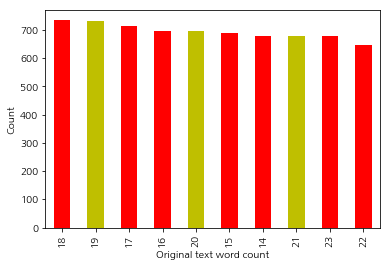

In [32]:
train['num_uniq_words'].value_counts()[0:10].plot(kind='bar',color=['r','y'])
plt.xlabel('Original text word count')
plt.ylabel('Count')

In [33]:
train['unique_word_fraction'] = train.apply(lambda row: unique_word_fraction(row), axis =1)
train['stopwords_count'] = train.apply(lambda row: stopwords_count(row), axis =1)
train['punctuations_fraction'] = train.apply(lambda row: punctuations_fraction(row), axis =1)
train['char_count'] = train.apply(lambda row: char_count(row), axis =1)
train['fraction_noun'] = train.apply(lambda row: fraction_noun(row), axis =1)
train['fraction_adj'] = train.apply(lambda row: fraction_adj(row), axis =1)
train['fraction_verbs'] = train.apply(lambda row: fraction_verbs(row), axis =1)
train.head()

,id,text,author,unique_words,stop_words,num_words,num_uniq_words,punctuations,upper_case,Title,...,sentences,words,text_len,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs
0,id26305,"this process, however, afford me no mean of as...",EAP,35,19,41,35,7,0,0,...,1,48,211,0.853659,0.487805,0.033175,211,0.341463,0.048780,0.097561
1,id17569,it never onc occur to me that the fumbl might ...,HPL,14,7,14,14,1,0,0,...,1,15,64,1.000000,0.500000,0.015625,64,0.214286,0.071429,0.142857
2,id11008,"in his left hand was a gold snuff box, from wh...",EAP,32,16,36,32,5,0,0,...,1,41,186,0.888889,0.472222,0.026882,186,0.333333,0.111111,0.111111
3,id27763,how love is spring as we look from windsor ter...,MWS,31,13,34,31,4,0,0,...,1,38,189,0.911765,0.382353,0.021164,189,0.382353,0.088235,0.147059
4,id12958,"find noth else, not even gold, the superintend...",HPL,25,11,27,25,4,0,0,...,1,31,148,0.925926,0.407407,0.027027,148,0.296296,0.037037,0.148148


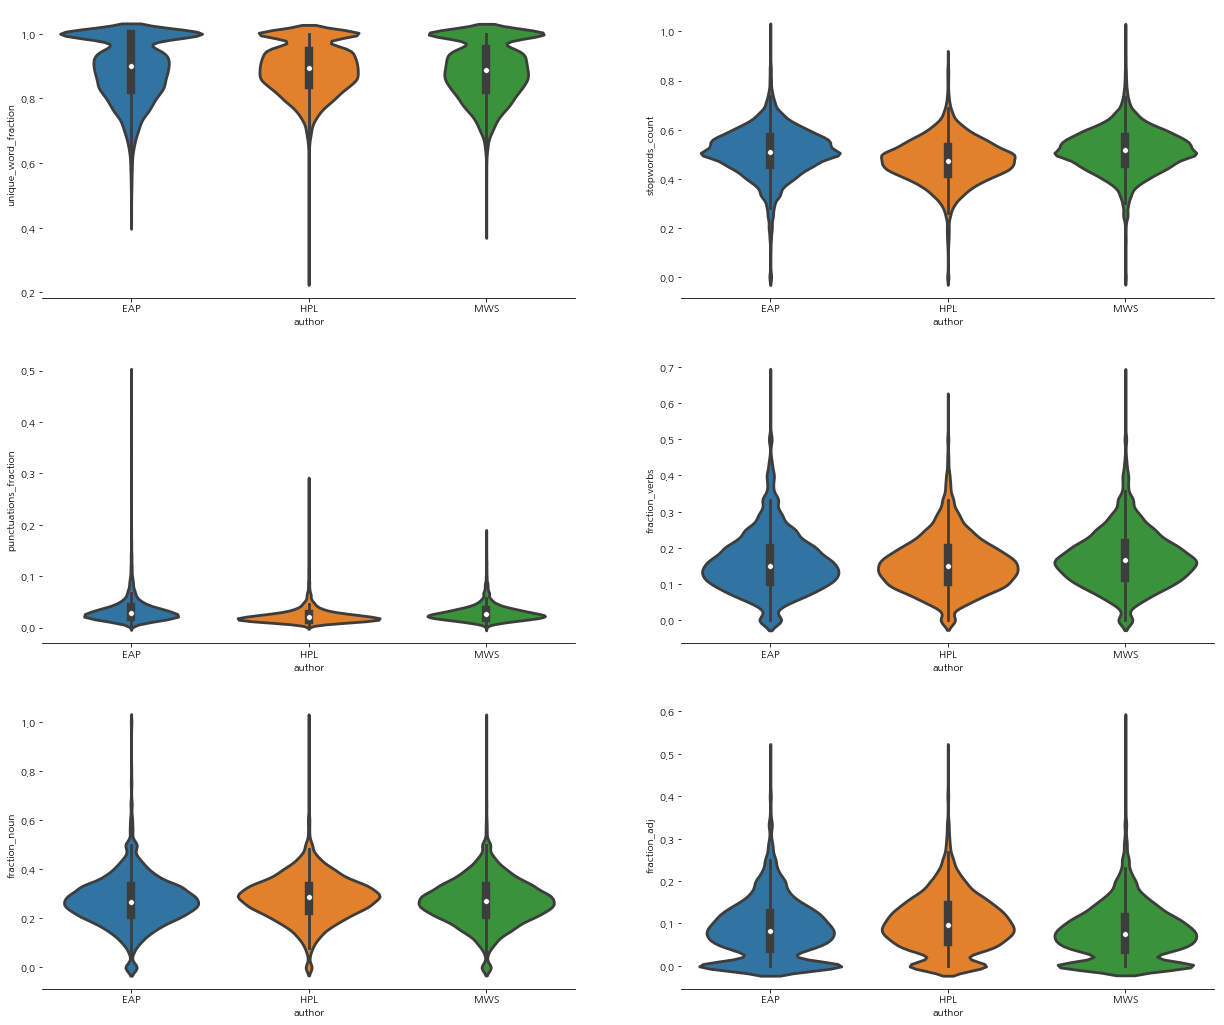

In [34]:
fig, axes = plt.subplots(3,2,figsize=(21, 18), sharex=True, sharey = False)
sns.despine(left=True)
sns.set_context("poster")
sns.violinplot(x="author", y="unique_word_fraction", data=train, ax = axes[0,0])
sns.violinplot(x="author", y="stopwords_count", data=train, ax = axes[0,1])
sns.violinplot(x="author", y="punctuations_fraction", data=train, ax = axes[1,0])
sns.violinplot(x="author", y="fraction_verbs", data=train, ax = axes[1,1])
sns.violinplot(x="author", y="fraction_noun", data=train, ax = axes[2,0])
sns.violinplot(x="author", y="fraction_adj", data=train, ax = axes[2,1])
sns.despine(left=True)

In [35]:
train_y = train.author.map({'EAP' : 0, 'HPL' : 1, 'MWS' : 2})

## Bag of words

In [36]:
vect = CountVectorizer(ngram_range=(1,2),min_df = 5).fit(train['text'])
train_vectorized = vect.transform(train['text'])
len(vect.get_feature_names())

20454

In [37]:
stack = train[['sentences', 'words', 'text_len']]
train_vectorized = scipy.sparse.hstack([train_vectorized,stack])
train_vectorized.shape

(19579, 20457)

In [38]:
model = LogisticRegression(C=.03,n_jobs = -1)
model.fit(train_vectorized , train['author'])

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
test_vectorized = vect.transform(test['text'])
stack1 = test[['sentences' , 'words' , 'text_len' ]]
test_vectorized = scipy.sparse.hstack([test_vectorized,stack1])

In [40]:
df = pd.DataFrame(model.predict_proba(test_vectorized), index= test['id'] , columns = ['EAP','HLP','MWS'])
df.head()

,EAP,HLP,MWS
id,,,
id02310,0.216110,0.102068,0.681822
id24541,0.782030,0.200145,0.017825
id00134,0.037002,0.858024,0.104975
id27757,0.644872,0.285097,0.070032
id04081,0.421351,0.209110,0.369539


## TF-IDF (Term frequency Inverse document frequency)
TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

...

특정 문서 내에서 단어 빈도가 높을 수록, 그리고 전체 문서들 중 그 단어를 포함한 문서가 적을 수록 TF-IDF값이 높아진다. 따라서 이 값을 이용하면 모든 문서에 흔하게 나타나는 단어를 걸러내는 효과를 얻을 수 있다. IDF의 로그 함수값은 항상 1 이상이므로, IDF값과 TF-IDF값은 항상 0 이상이 된다. 특정 단어를 포함하는 문서들이 많을 수록 로그 함수 안의 값이 1에 가까워지게 되고, 이 경우 IDF값과 TF-IDF값은 0에 가까워지게 된다.

출처 :
[TF-IDF - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/TF-IDF)

자주 사용 되는 단어는 오히려 별로 중요하지 않은 단어일 수도 있다. 예를 들어 조사나 this, that, is, a, the 같은 단어들, 그래서 이 값의 역수를 곱해 단어의 가중치를 주게 된다.

In [41]:
tfidf_vec = TfidfVectorizer(stop_words = 'english', max_features=100000, min_df=2, ngram_range = (1,3))
full_tfidfvet = tfidf_vec.fit_transform(train["text"].values.tolist() + test["text"].values.tolist())
train_tfidfvec = tfidf_vec.fit_transform(train["text"].values.tolist())
test_tfidfvec = tfidf_vec.fit_transform(test["text"].values.tolist())

## TruncatedSVD
* 잠재의미분석이란 위와 같은 단어-문서행렬(Word-Document Matrix), 단어-문맥행렬(window based co-occurrence matrix) 등 입력 데이터에 특이값 분해를 수행해 데이터의 차원수를 줄여 계산 효율성을 키우는 한편 행간에 숨어있는(latent) 의미를 이끌어내기 위한 방법론입니다. 
* 참고 : [SVD와 PCA, 그리고 잠재의미분석(LSA) · ratsgo's blog](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/04/06/pcasvdlsa/)

In [42]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm = 'arpack')
svd_obj.fit(full_tfidfvet)
train_svd = pd.DataFrame(svd_obj.fit_transform(train_tfidfvec))
test_svd = pd.DataFrame(svd_obj.fit_transform(test_tfidfvec))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train , train_svd], axis = 1)
test = pd.concat([test , test_svd], axis = 1)

del full_tfidfvet, train_tfidfvec, test_tfidfvec, train_svd, test_svd

In [43]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model


In [44]:
cols_to_drop = ['id', 'text']

train_X = train.drop(cols_to_drop + ['author'], axis = 1)
test_X = test.drop(cols_to_drop, axis = 1)
train_X.head()

,unique_words,stop_words,num_words,num_uniq_words,punctuations,upper_case,Title,split,sentences,words,...,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19
0,35,19,41,35,7,0,0,"[this, process, ,, however, ,, afford, me, no,...",1,48,...,0.006094,0.023242,0.004450,-0.027346,-0.023137,-0.027879,0.047409,-0.007960,-0.011958,0.019300
1,14,7,14,14,1,0,0,"[it, never, onc, occur, to, me, that, the, fum...",1,15,...,0.003263,-0.003128,-0.002500,0.001412,-0.025202,-0.005097,0.012525,-0.013125,-0.004489,0.026113
2,32,16,36,32,5,0,0,"[in, his, left, hand, was, a, gold, snuff, box...",1,41,...,0.001534,-0.002145,-0.005208,-0.041824,0.002295,-0.034936,0.055512,-0.015825,-0.009772,-0.019466
3,31,13,34,31,4,0,0,"[how, love, is, spring, as, we, look, from, wi...",1,38,...,-0.021564,-0.047866,-0.009149,0.051120,0.131150,-0.004976,-0.042249,0.130247,-0.099996,0.039453
4,25,11,27,25,4,0,0,"[find, noth, else, ,, not, even, gold, ,, the,...",1,31,...,-0.025978,0.003024,0.018396,0.014649,0.027301,-0.022906,-0.054193,0.099311,-0.069965,0.034785


In [45]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
print(train.shape[0])
pred_train = np.zeros([train.shape[0], 3])
print(pred_train.shape)

19579
(19579, 3)


In [47]:
# for dev_index, val_index in kf.split(train_X):
#     dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
#     dev_y, val_y = train_y[dev_index], train_y[val_index]
#     pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
#     pred_full_test = pred_full_test + pred_test_y
#     pred_train[val_index,:] = pred_val_y
#     cv_scores.append(metrics.log_loss(val_y, pred_val_y))
#     break
# print("cv scores : ", cv_scores)

In [ ]:
print('Mean accuracy score',np.mean(cv_scores))

In [ ]:
# 0.743397966206

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
xgb.plot_importance(model, max_num_features = 50, height = 0.8, ax=ax)
plt.show()

In [ ]:
y_pred = pred_full_test/2
submit = pd.DataFrame(test['id'])
submit = submit.join(pd.DataFrame(y_pred))
submit.columns = ['id','EAP','HPL','MWS'] 
submit.head()

In [ ]:
submit.to_csv("data/submission.csv", index=False,compression='gzip')